### 2 cycles 

In [1]:
"""
end_to_end_estimation.py

One-system Estimation / Oh Hell trainer:
- Distributional Bidder (PyTorch): P(tricks = k | hand, trump), picks bid maximizing Estimation score
- Playing Agent (MaskablePPO): learns to hit the chosen bid (seat 0 only)
- Opponents (seats 1–3): follow suit and play a high legal card with slight randomness (±2 ranks of best)
- Alternating training: Player RL steps <-> Bidder supervised calibration on realized trick counts
- Final test: run 13 deals and compare total Oh Hell points of seat 0 vs all other seats
- Rich tracking — TensorBoard + CSV logs, periodic eval callback logging task metrics
- Faster wall-clock (no learning compromises):
    * SubprocVecEnv parallelism (keep rollout size constant)
    * O(1) rank lookups
    * Thread settings for BLAS / Torch
    * Quieter console

Run (example):
  python end_to_end_estimation.py --cycles 5 --player_steps 2000000 --bidder_rollouts 120000 --bidder_epochs 8 --eval_episodes 300 --log_dir runs/exp1 --eval_freq 20000 --n_envs 8
"""

# ==========================
# Fast-thread settings FIRST
# ==========================
import os
# Set BEFORE importing numpy / torch / sb3 (they may create thread pools on import)
os.environ.setdefault("OMP_NUM_THREADS", "8")   # tune to your CPU
os.environ.setdefault("MKL_NUM_THREADS", "8")   # tune to your CPU

import sys
import math
import random
import argparse
import csv
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# ---- Safe imports for RL; show a clear message if missing ----
try:
    from sb3_contrib import MaskablePPO
    from sb3_contrib.common.wrappers import ActionMasker
    from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
    from stable_baselines3.common.callbacks import BaseCallback
    from stable_baselines3.common.logger import configure as sb3_logger_configure
except Exception as e:
    raise RuntimeError(
        'Stable-Baselines3 and sb3-contrib are required.\n'
        'Install with:\n  pip install "stable-baselines3>=2.3.0" "sb3-contrib>=2.3.0"'
    ) from e

# ---- PyTorch for the bidder ----
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    # Use CPU threads effectively
    try:
        torch.set_num_threads(int(os.environ.get("OMP_NUM_THREADS", "8")))
    except Exception:
        pass
    # Slightly faster matmul kernels on CPU for PyTorch 2.x
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass
except Exception as e:
    raise RuntimeError(
        'PyTorch is required for the bidder.\n'
        'Install with:\n  pip install torch'
    ) from e

import gymnasium as gym
from gymnasium import spaces


# ================
# CSV helper
# ================
def _append_row_csv(path: str, row: dict):
    """Append a row (dict) to CSV, writing headers on first write."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    write_header = not os.path.exists(path)
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if write_header:
            w.writeheader()
        w.writerow(row)


# ================
# Card definitions
# ================
SUITS = ["H", "S", "D", "C"]
RANKS = ["2","3","4","5","6","7","8","9","10","J","Q","K","A"]
RANK_TO_IDX = {r: i for i, r in enumerate(RANKS)}  # O(1) rank lookup
PAD = 52
CARD_IDX = {f"{r}{s}": i for i, (s, r) in enumerate((s, r) for s in SUITS for r in RANKS)}
IDX_CARD = {v: k for k, v in CARD_IDX.items()}

def card_suit(card: str) -> str:
    return card[-1]

def card_rank(card: str) -> str:
    return card[:-1]

def get_trick_winner(trick: List[str], trump: Optional[str]) -> int:
    """Winner: any trump beats non-trump; otherwise highest rank in led suit."""
    lead_suit = card_suit(trick[0])
    best_idx = 0
    best_card = trick[0]
    for i, card in enumerate(trick[1:], 1):
        c_suit, b_suit = card_suit(card), card_suit(best_card)
        if trump is not None:
            if c_suit == trump and b_suit != trump:
                best_idx, best_card = i, card
                continue
            if c_suit == trump and b_suit == trump:
                if RANK_TO_IDX[card_rank(card)] > RANK_TO_IDX[card_rank(best_card)]:
                    best_idx, best_card = i, card
                continue
        # compare within led suit if best isn't trump
        if (trump is None or b_suit != trump) and c_suit == lead_suit:
            if RANK_TO_IDX[card_rank(card)] > RANK_TO_IDX[card_rank(best_card)]:
                best_idx, best_card = i, card
    return best_idx

def lowest_legal_index(hand: List[str], led: Optional[str]) -> int:
    indices = list(range(len(hand)))
    if led is not None and any(card_suit(c) == led for c in hand):
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices if card_suit(hand[i]) == led]
    else:
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices]
    candidates.sort()
    return candidates[0][1]

def highest_with_fuzz_legal_index(hand: List[str], led: Optional[str]) -> int:
    """
    Improved opponent heuristic:
      - If led suit is present: consider only cards in led suit.
      - Otherwise: consider all cards.
      - Play a high card, with randomness: choose among cards within ±2 ranks of the highest.
    """
    indices = list(range(len(hand)))
    if len(indices) == 0:
        return 0
    if led is not None and any(card_suit(c) == led for c in hand):
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices if card_suit(hand[i]) == led]
    else:
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices]
    candidates.sort(reverse=True)
    top_rank = candidates[0][0]
    threshold = max(0, top_rank - 2)
    near_top = [pair for pair in candidates if pair[0] >= threshold]
    choice = random.choice(near_top) if near_top else candidates[0]
    return choice[1]


# ===================
# Playing environment
# ===================
class PlayingEnvSeat0(gym.Env):
    """
    4-player trick-taking env; only seat 0 is controlled by the agent.
    Seats 1..3 play a stronger legal policy:
      - Follow suit if possible
      - Otherwise free choice
      - Prefer the highest legal card, with slight randomness: choose among cards within ±2 ranks of the highest.

    - 52 cards, 13-card hands, 13 tricks
    - trump suit provided externally each episode
    - follow-suit enforced
    - action masking for seat 0
    - dense shaping toward the bid (seat 0) + terminal Estimation scoring
    """
    metadata = {"render_modes": []}

    def __init__(self):
        super().__init__()
        self.num_players = 4
        self.hand_size = 13
        self.deck = [f"{r}{s}" for s in SUITS for r in RANKS]

        self.bids = [0,0,0,0]
        self.trump: Optional[str] = None

        self.action_space = spaces.Discrete(self.hand_size)
        self.observation_space = spaces.Dict({
            "hand":   spaces.MultiDiscrete([PAD + 1] * self.hand_size),
            "trick":  spaces.MultiDiscrete([PAD + 1] * 4),
            "bids":   spaces.MultiDiscrete([14] * 4),
            "won":    spaces.MultiDiscrete([14] * 4),
            "trump":  spaces.Discrete(4),
            "seat":   spaces.Discrete(4),
            "leader": spaces.Discrete(4),
        })

        self.players: List[List[str]] = [[] for _ in range(self.num_players)]
        self.won_tricks = [0]*self.num_players
        self.current_trick: List[str] = []
        self.current_player = 0
        self.leader = 0
        self.trick_history: List[List[str]] = []

        self._prev_abs_diff = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        deck = self.deck[:]
        random.shuffle(deck)
        self.players = [deck[i*self.hand_size:(i+1)*self.hand_size] for i in range(self.num_players)]
        self.won_tricks = [0]*self.num_players
        self.current_trick = []
        self.trick_history = []
        self.current_player = self.leader = 0
        self._prev_abs_diff = abs(self.won_tricks[0] - self.bids[0])
        return self._get_obs(), {}

    def _pad_cards(self, cards: List[str], target_len: int) -> np.ndarray:
        arr = [CARD_IDX[c] for c in cards] + [PAD] * (target_len - len(cards))
        return np.array(arr, dtype=np.int64)

    def _get_obs(self):
        trump_idx = SUITS.index(self.trump) if self.trump is not None else 0
        return {
            "hand":   self._pad_cards(self.players[0], self.hand_size),
            "trick":  self._pad_cards(self.current_trick, 4),
            "bids":   np.array(self.bids, dtype=np.int64),
            "won":    np.array(self.won_tricks, dtype=np.int64),
            "trump":  np.array(trump_idx, dtype=np.int64),
            "seat":   np.array(0, dtype=np.int64),
            "leader": np.array(self.leader, dtype=np.int64),
        }

    def _legal_action_mask(self):
        mask = np.zeros(self.hand_size, dtype=np.int8)
        hand = self.players[0]
        n = len(hand)
        if n == 0:
            return mask
        mask[:n] = 1
        if len(self.current_trick) == 0 or self.current_player != 0:
            return mask
        led = card_suit(self.current_trick[0])
        if any(card_suit(c) == led for c in hand):
            for i in range(n):
                if card_suit(hand[i]) != led:
                    mask[i] = 0
        return mask

    def _opponent_play_one_card(self):
        assert self.current_player != 0
        hand = self.players[self.current_player]
        led = card_suit(self.current_trick[0]) if len(self.current_trick) > 0 else None
        idx = highest_with_fuzz_legal_index(hand, led)
        card = hand.pop(idx)
        self.current_trick.append(card)
        if len(self.current_trick) == 4:
            winner_offset = get_trick_winner(self.current_trick, trump=self.trump)
            winner = (self.leader + winner_offset) % self.num_players
            self.won_tricks[winner] += 1
            self.trick_history.append(self.current_trick[:])
            self.current_trick.clear()
            self.leader = winner
            self.current_player = winner
        else:
            self.current_player = (self.current_player + 1) % self.num_players

    def _advance_to_seat0_or_end(self) -> float:
        shaping = 0.0
        while len(self.trick_history) < self.hand_size and self.current_player != 0:
            prev = abs(self.won_tricks[0] - self.bids[0])
            self._opponent_play_one_card()
            new = abs(self.won_tricks[0] - self.bids[0])
            if len(self.current_trick) == 0:
                shaping += (prev - new)
        return shaping

    def step(self, action: int):
        if len(self.trick_history) == self.hand_size:
            return self._get_obs(), 0.0, True, False, {"action_mask": self._legal_action_mask()}

        total_reward = 0.0

        if self.current_player != 0:
            total_reward += self._advance_to_seat0_or_end()
            if len(self.trick_history) == self.hand_size:
                final = self._final_score()
                return self._get_obs(), total_reward + final, True, False, {"action_mask": self._legal_action_mask()}

        hand = self.players[0]
        if not (0 <= action < len(hand)):
            raise IndexError(f"Invalid action {action} for hand length {len(hand)}")

        card = hand.pop(action)
        self.current_trick.append(card)

        if len(self.current_trick) == 4:
            prev = abs(self.won_tricks[0] - self.bids[0])
            winner_offset = get_trick_winner(self.current_trick, trump=self.trump)
            winner = (self.leader + winner_offset) % self.num_players
            self.won_tricks[winner] += 1
            self.trick_history.append(self.current_trick[:])
            self.current_trick.clear()
            self.leader = winner
            self.current_player = winner
            new = abs(self.won_tricks[0] - self.bids[0])
            total_reward += (prev - new)
        else:
            self.current_player = (self.current_player + 1) % self.num_players

        total_reward += self._advance_to_seat0_or_end()

        done = len(self.trick_history) == self.hand_size
        if done:
            total_reward += self._final_score()

        info = {"action_mask": self._legal_action_mask()}
        return self._get_obs(), total_reward, done, False, info

    def _final_score(self) -> float:
        bid = self.bids[0]
        won = self.won_tricks[0]
        return (10 + bid) if won == bid else -abs(won - bid)


# ===========================
# Distributional bidder (NN)
# ===========================
def encode_features(hand: List[str], trump: str) -> np.ndarray:
    x = np.zeros(56, dtype=np.float32)
    for c in hand:
        x[CARD_IDX[c]] = 1.0
    x[52 + SUITS.index(trump)] = 1.0
    return x

class BidderNet(nn.Module):
    def __init__(self, in_dim=56, hidden=256, dropout=0.1, out_dim=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

@dataclass
class Bidder:
    model: BidderNet
    device: str = "cpu"

    @staticmethod
    def create(device: Optional[str] = None) -> "Bidder":
        if device is None or device == "auto":
            device = "cuda" if torch.cuda.is_available() else "cpu"
        m = BidderNet().to(device)
        return Bidder(model=m, device=device)

    def save(self, path: str):
        torch.save(self.model.state_dict(), path)

    def load(self, path: str):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.eval()

    @torch.no_grad()
    def predict_distribution(self, hand: List[str], trump: str) -> np.ndarray:
        x = torch.from_numpy(encode_features(hand, trump)).unsqueeze(0).to(self.device)
        logits = self.model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        return probs

    def pick_bid_max_expected_score(self, probs: np.ndarray) -> int:
        k = np.arange(14)
        best_b, best_val = 0, -1e9
        for b in range(14):
            expected = probs[b] * (10 + b) + np.sum(probs * (-np.abs(k - b)))
            if expected > best_val:
                best_val, best_b = expected, b
        return int(best_b)

    def train_supervised(self, X: np.ndarray, y: np.ndarray,
                         epochs: int = 6, batch_size: int = 2048, lr: float = 1e-3, seed: int = 42):
        torch.manual_seed(seed)
        self.model.train()
        opt = optim.AdamW(self.model.parameters(), lr=lr)
        crit = nn.CrossEntropyLoss()

        X_t = torch.from_numpy(X).to(self.device)
        y_t = torch.from_numpy(y.astype(np.int64)).to(self.device)

        n = X.shape[0]
        steps = math.ceil(n / batch_size) if n > 0 else 0
        for ep in range(1, epochs + 1):
            if n == 0:
                print(f"[Bidder] Epoch {ep}/{epochs}  loss=0.0000 (no data)")
                continue
            perm = torch.randperm(n, device=self.device)
            total = 0.0
            for b in range(steps):
                idx = perm[b*batch_size:(b+1)*batch_size]
                xb, yb = X_t[idx], y_t[idx]
                opt.zero_grad()
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
                total += loss.item() * xb.size(0)
            avg = total / n
            print(f"[Bidder] Epoch {ep}/{epochs}  loss={avg:.4f}")
        self.model.eval()


# ==========================
# Wrapper: inject bids/trump
# ==========================
def deterministic_trump_from_seed(seed: int) -> str:
    return SUITS[seed % 4]

class DealBidInjectingEnv(PlayingEnvSeat0):
    def __init__(self, bidder: Bidder):
        super().__init__()
        self._bidder = bidder
        self._last_hand0: List[str] = []
        self._last_features: Optional[np.ndarray] = None

    def reset(self, seed=None, options=None):
        self._shared_seed = int(np.random.randint(0, 2**31-1)) if seed is None else int(seed)
        obs, info = super().reset(seed=self._shared_seed, options=options)
        self.trump = deterministic_trump_from_seed(self._shared_seed)
        self._last_hand0 = self.players[0][:]
        probs = self._bidder.predict_distribution(self._last_hand0, self.trump)
        bid0 = self._bidder.pick_bid_max_expected_score(probs)

        def simple_bid_bot(hand: List[str], trump: str) -> int:
            high_trump = {"A","10","K","Q","J"}
            high = {"A","10","K"}
            v = sum(1 for c in hand if card_suit(c)==trump and card_rank(c) in high_trump) \
                + sum(1 for c in hand if card_rank(c) in high)
            v += random.choice([-2,-1,0,1,2])
            return max(0, min(13, v))

        bids = [bid0] + [simple_bid_bot(self.players[i], self.trump) for i in range(1,4)]
        self.bids = bids
        self._last_features = encode_features(self._last_hand0, self.trump)
        return self._get_obs(), info


# ==========================
# RL utilities & evaluation
# ==========================
def mask_fn(env: PlayingEnvSeat0):
    return env._legal_action_mask()

def make_vec_env(bidder: Bidder, n_envs: int = 8, use_subproc: bool = True):
    def _make():
        e = DealBidInjectingEnv(bidder)
        return ActionMasker(e, mask_fn)
    if n_envs == 1:
        return DummyVecEnv([_make])
    if use_subproc:
        return SubprocVecEnv([_make for _ in range(n_envs)])
    return DummyVecEnv([_make for _ in range(n_envs)])

def evaluate_player(model: MaskablePPO, bidder: Bidder, episodes: int = 50):
    env = ActionMasker(DealBidInjectingEnv(bidder), mask_fn)
    returns, hits, within1 = [], 0, 0
    for _ in range(episodes):
        obs, _ = env.reset()
        ep_ret, done = 0.0, False
        while not done:
            base = env.unwrapped
            mask = base._legal_action_mask()
            action, _ = model.predict(obs, deterministic=True, action_masks=mask)
            obs, reward, done, truncated, _ = env.step(int(action))
            ep_ret += float(reward)
            if truncated:
                break
        returns.append(ep_ret)
        b0, w0 = base.bids[0], base.won_tricks[0]
        if b0 == w0: hits += 1
        if abs(b0 - w0) <= 1: within1 += 1
    mean, std = float(np.mean(returns)), float(np.std(returns))
    hit_rate = hits/episodes
    within1_rate = within1/episodes
    print(f"[Eval] {episodes} eps  mean={mean:.3f} ± {std:.3f} | hit_exact={hit_rate:.3f} | within±1={within1_rate:.3f}")
    return {
        "episodes": episodes,
        "mean_return": mean,
        "std_return": std,
        "hit_exact": hit_rate,
        "within1": within1_rate,
    }

def oh_hell_points(bid: int, won: int) -> int:
    return (10 + bid) if won == bid else -abs(won - bid)

def run_13_deal_match(model: MaskablePPO, bidder: Bidder, seed: Optional[int] = None,
                      csv_path: Optional[str] = None) -> List[int]:
    totals = [0, 0, 0, 0]
    env = ActionMasker(DealBidInjectingEnv(bidder), mask_fn)
    rng = random.Random(seed)

    deal_rows = []

    for d in range(13):
        deal_seed = None if seed is None else (rng.randrange(0, 2**31 - 1))
        obs, _ = env.reset(seed=deal_seed)
        done = False
        while not done:
            base = env.unwrapped
            mask = base._legal_action_mask()
            action, _ = model.predict(obs, deterministic=True, action_masks=mask)
            obs, reward, done, truncated, _ = env.step(int(action))
            if truncated:
                break
        base = env.unwrapped
        pts = [oh_hell_points(base.bids[s], base.won_tricks[s]) for s in range(4)]
        for s in range(4):
            totals[s] += pts[s]

        print(f"[Deal {d+1:02d}] Bids={base.bids}  Won={base.won_tricks}  Points={pts}")

        row = {
            "deal": d + 1,
            "bid_s0": base.bids[0], "bid_s1": base.bids[1], "bid_s2": base.bids[2], "bid_s3": base.bids[3],
            "won_s0": base.won_tricks[0], "won_s1": base.won_tricks[1], "won_s2": base.won_tricks[2], "won_s3": base.won_tricks[3],
            "pts_s0": pts[0], "pts_s1": pts[1], "pts_s2": pts[2], "pts_s3": pts[3],
            "cum_s0": totals[0], "cum_s1": totals[1], "cum_s2": totals[2], "cum_s3": totals[3],
        }
        deal_rows.append(row)

    print("\n[13-Deal Match] Total points:")
    for s in range(4):
        tag = "Seat0 (Agent)" if s == 0 else f"Seat{s}"
        print(f"  {tag}: {totals[s]}")
    ranking = sorted([(totals[s], s) for s in range(4)], reverse=True)
    rank_str = " > ".join([("Seat0* (Agent)" if s == 0 else f"Seat{s}") for _, s in ranking])
    print(f"[13-Deal Match] Ranking: {rank_str}")

    if csv_path is not None:
        # ensure a fresh file
        try:
            if os.path.exists(csv_path):
                os.remove(csv_path)
        except Exception:
            pass
        # write all deals
        for r in deal_rows:
            _append_row_csv(csv_path, r)
        # add a final TOTALS row
        totals_row = {
            "deal": "TOTALS",
            "bid_s0": "", "bid_s1": "", "bid_s2": "", "bid_s3": "",
            "won_s0": "", "won_s1": "", "won_s2": "", "won_s3": "",
            "pts_s0": "", "pts_s1": "", "pts_s2": "", "pts_s3": "",
            "cum_s0": totals[0], "cum_s1": totals[1], "cum_s2": totals[2], "cum_s3": totals[3],
        }
        _append_row_csv(csv_path, totals_row)

    return totals


# ==========================
# Periodic Eval Callback
# ==========================
class PeriodicEvalCallback(BaseCallback):
    """
    Runs short deterministic evaluations every eval_freq steps with the current bidder,
    logs metrics to SB3 logger (TensorBoard/CSV/stdout).
    """
    def __init__(self, bidder: Bidder, eval_episodes: int = 10, eval_freq: int = 50_000, verbose: int = 0):
        super().__init__(verbose)
        self.bidder = bidder
        self.eval_episodes = eval_episodes
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            metrics = evaluate_player(self.model, self.bidder, episodes=self.eval_episodes)
            # Log to SB3 logger
            self.model.logger.record("eval/mean_return", metrics["mean_return"])
            self.model.logger.record("eval/std_return", metrics["std_return"])
            self.model.logger.record("eval/hit_exact", metrics["hit_exact"])
            self.model.logger.record("eval/within1", metrics["within1"])
            self.model.logger.dump(self.num_timesteps)
        return True


# ==========================
# Plotting utilities
# ==========================
def _ema(y, a=0.1):
    if a <= 0: return y
    out=[]; m=None
    for v in y: m=v if m is None else a*v + (1-a)*m; out.append(m)
    return np.array(out)

def _coalesce_timesteps(df):
    for c in ["time/total_timesteps","total_timesteps","timesteps"]:
        if c in df.columns:
            return df.rename(columns={c:"total_timesteps"})
    df = df.copy(); df["total_timesteps"] = np.arange(len(df)); return df

def _plot_series(df, cols, title, ylabel, out_path, smooth=0.1):
    plt.figure(figsize=(8,5))
    any_plot = False
    for c in cols:
        if c in df.columns:
            plt.plot(df["total_timesteps"].values, _ema(df[c].values, smooth), label=c)
            any_plot = True
    if not any_plot:
        print(f"[Plots] Skipped {title}: none of {cols} found"); return
    plt.xlabel("Total timesteps"); plt.ylabel(ylabel); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(out_path + ".png", dpi=150); plt.savefig(out_path + ".pdf"); plt.close()

def plot_learning_curves(log_dir, out_dir=None, smooth=0.1):
    paths = glob(os.path.join(log_dir, "**", "progress.csv"), recursive=True)
    if not paths:
        print(f"[Plots] No progress.csv under {log_dir}"); return
    dfs = []
    for p in sorted(paths):
        try:
            d = pd.read_csv(p); d["__src"] = p; dfs.append(d)
        except Exception as e:
            print(f"[Plots] Skip {p}: {e}")
    if not dfs:
        print("[Plots] No readable CSV logs."); return
    df = pd.concat(dfs, ignore_index=True, sort=False)
    df = _coalesce_timesteps(df)
    df = df.sort_values("total_timesteps").drop_duplicates(subset=["total_timesteps","__src"], keep="last")
    out_dir = out_dir or os.path.join(log_dir, "plots")
    os.makedirs(out_dir, exist_ok=True)
    _plot_series(df,
        ["eval/mean_return","cycle/post_player/mean_return","cycle/post_bidder/mean_return","final/mean_return"],
        "Learning: Mean Return vs Timesteps","Mean episodic return", os.path.join(out_dir, "mean_return"), smooth)
    _plot_series(df,
        ["eval/hit_exact","cycle/post_player/hit_exact","cycle/post_bidder/hit_exact","final/hit_exact"],
        "Learning: Exact-Hit Rate vs Timesteps","Exact-hit rate", os.path.join(out_dir, "hit_exact"), smooth)
    _plot_series(df,
        ["eval/within1","cycle/post_player/within1","cycle/post_bidder/within1","final/within1"],
        "Learning: Within ±1 Rate vs Timesteps","Within ±1 rate", os.path.join(out_dir, "within1"), smooth)
    print(f"[Plots] Saved to {out_dir}")


# ==========================
# Alternating training loop
# ==========================
def collect_bidder_dataset(player: MaskablePPO, bidder: Bidder, n_episodes: int) -> Tuple[np.ndarray, np.ndarray]:
    env = ActionMasker(DealBidInjectingEnv(bidder), mask_fn)
    X_list, y_list = [], []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        base = env.unwrapped
        done = False
        while not done:
            mask = base._legal_action_mask()
            action, _ = player.predict(obs, deterministic=True, action_masks=mask)
            obs, reward, done, truncated, _ = env.step(int(action))
            if truncated:
                break
        feats = base._last_features
        label = base.won_tricks[0]
        if feats is not None:
            X_list.append(feats)
            y_list.append(int(label))
    X = np.stack(X_list, axis=0) if X_list else np.zeros((0,56), dtype=np.float32)
    y = np.array(y_list, dtype=np.int64) if y_list else np.zeros((0,), dtype=np.int64)
    print(f"[Dataset] Collected {len(y)} bidder samples.")
    return X, y


def alternating_train(
    cycles: int = 3,
    player_steps: int = 600_000,
    bidder_rollouts: int = 30_000,
    bidder_epochs: int = 6,
    seed: int = 42,
    save_dir: str = "ckpts",
    eval_episodes: int = 100,
    log_dir: str = "runs/exp",
    eval_freq: int = 50_000,
    tb_log_name: str = "MaskablePPO",
    n_envs: int = 8,                # NEW: parallel envs
):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # init bidder
    bidder = Bidder.create(device="auto")

    # init player with parallel envs; keep rollout-size constant (n_steps*n_envs == 1024)
    vec_env = make_vec_env(bidder, n_envs=n_envs, use_subproc=True)
    target_rollout = 1024
    n_steps = max(64, target_rollout // max(1, n_envs))

    player = MaskablePPO(
        policy="MultiInputPolicy",
        env=vec_env,
        seed=seed,
        verbose=0,                 # quieter -> less overhead
        n_steps=n_steps,
        batch_size=256,
        learning_rate=3e-4,
        ent_coef=0.01,
        clip_range=0.2,
        gamma=0.99,
        gae_lambda=0.95,
        n_epochs=10,
        tensorboard_log=log_dir
    )

    # Configure SB3 logger to also write CSV + stdout
    sb3_logger = sb3_logger_configure(log_dir, ["stdout", "csv", "tensorboard"])
    player.set_logger(sb3_logger)

    for cyc in range(1, cycles + 1):
        print(f"\n=== CYCLE {cyc}/{cycles}: Train PLAYER ({player_steps:,} steps) with current BIDDER ===")
        callback = PeriodicEvalCallback(
            bidder=bidder,
            eval_episodes=max(5, eval_episodes//10),
            eval_freq=eval_freq,
            verbose=0
        )
        player.learn(total_timesteps=player_steps, progress_bar=False, callback=callback, tb_log_name=f"{tb_log_name}_cycle{cyc}")

        # save checkpoint
        player_path = os.path.join(save_dir, f"player_cycle{cyc}")
        player.save(player_path)
        bidder_path = os.path.join(save_dir, f"bidder_cycle{cyc}.pt")
        bidder.save(bidder_path)
        print(f"[Save] {player_path}.zip and {bidder_path}")

        # --- Evaluate after player training ---
        print(f"\n--- Evaluate after player training ---")
        eval_ep = max(20, eval_episodes//5)
        metrics_player = evaluate_player(player, bidder, episodes=eval_ep)

        # Log to SB3
        player.logger.record("cycle/post_player/mean_return", metrics_player["mean_return"])
        player.logger.record("cycle/post_player/std_return",  metrics_player["std_return"])
        player.logger.record("cycle/post_player/hit_exact",   metrics_player["hit_exact"])
        player.logger.record("cycle/post_player/within1",     metrics_player["within1"])
        player.logger.dump(player.num_timesteps)

        # Save to per-cycle CSV
        cycle_csv = os.path.join(log_dir, f"cycle_{cyc}.csv")
        row_player = {
            "cycle": cyc,
            "phase": "post_player",
            "timesteps": player.num_timesteps,
            **metrics_player,
        }
        _append_row_csv(cycle_csv, row_player)

        # --- Train BIDDER on realized tricks ---
        print(f"\n=== CYCLE {cyc}/{cycles}: Train BIDDER on realized tricks from current PLAYER ===")
        X, y = collect_bidder_dataset(player, bidder, n_episodes=bidder_rollouts)
        if len(y) == 0:
            print("[Warn] No data collected for bidder; skipping bidder update.")
        else:
            bidder.train_supervised(X, y, epochs=bidder_epochs, batch_size=8192, lr=1e-3, seed=seed)
            bidder_updated_path = os.path.join(save_dir, f"bidder_cycle{cyc}_updated.pt")
            bidder.save(bidder_updated_path)

        # rebind env to use updated bidder
        vec_env = make_vec_env(bidder, n_envs=n_envs, use_subproc=True)
        player.set_env(vec_env)

        # --- Evaluate after bidder update ---
        print(f"\n--- Evaluate after bidder update ---")
        metrics_bidder = evaluate_player(player, bidder, episodes=eval_ep)

        # Log to SB3
        player.logger.record("cycle/post_bidder/mean_return", metrics_bidder["mean_return"])
        player.logger.record("cycle/post_bidder/std_return",  metrics_bidder["std_return"])
        player.logger.record("cycle/post_bidder/hit_exact",   metrics_bidder["hit_exact"])
        player.logger.record("cycle/post_bidder/within1",     metrics_bidder["within1"])
        player.logger.dump(player.num_timesteps)

        # Append to same per-cycle CSV
        row_bidder = {
            "cycle": cyc,
            "phase": "post_bidder",
            "timesteps": player.num_timesteps,
            **metrics_bidder,
        }
        _append_row_csv(cycle_csv, row_bidder)

    # === FINAL EVALUATION ===
    print("\n=== FINAL EVALUATION ===")
    final_metrics = evaluate_player(player, bidder, episodes=eval_episodes)
    player.logger.record("final/mean_return", final_metrics["mean_return"])
    player.logger.record("final/std_return",  final_metrics["std_return"])
    player.logger.record("final/hit_exact",   final_metrics["hit_exact"])
    player.logger.record("final/within1",     final_metrics["within1"])
    player.logger.dump(player.num_timesteps)

    # Save final eval CSV
    final_csv = os.path.join(log_dir, "final_eval.csv")
    _append_row_csv(final_csv, {
        "phase": "final",
        "timesteps": player.num_timesteps,
        **final_metrics,
    })

    # === 13-DEAL MATCH ===
    print("\n=== 13-DEAL MATCH VS OPPONENTS (NORMAL OH HELL SCORING) ===")
    match_csv = os.path.join(log_dir, "match13_deals.csv")
    try:
        if os.path.exists(match_csv):
            os.remove(match_csv)
    except Exception:
        pass
    totals = run_13_deal_match(player, bidder, seed=seed, csv_path=match_csv)

    # Log 13-deal totals to SB3
    player.logger.record("match13/seat0_agent", totals[0])
    player.logger.record("match13/seat1", totals[1])
    player.logger.record("match13/seat2", totals[2])
    player.logger.record("match13/seat3", totals[3])
    player.logger.record("match13/agent_is_best", float(totals[0] == max(totals)))
    player.logger.dump(player.num_timesteps)

    # Save final models
    final_player = os.path.join(save_dir, "player_final")
    final_bidder = os.path.join(save_dir, "bidder_final.pt")
    player.save(final_player)
    bidder.save(final_bidder)
    print(f"[Final Save] {final_player}.zip and {final_bidder}")

    # Plots at end (optional)
    try:
        plot_learning_curves(log_dir, out_dir=os.path.join(log_dir, "plots"), smooth=0.1)
    except Exception as e:
        print(f"[Plots] Skipped (reason: {e})")


### Sensetivity analysis


In [ ]:
# === Timestep Sensitivity (uses the already-defined alternating_train) ===
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- Sweep setup (edit as needed) ----------
cycles = 2                 # total PPO steps = cycles * player_steps_per_cycle
player_steps_list = [12_500, 25_000, 50_000, 100_000, 200_000, 400_000, 800_000]

bidder_rollouts = 20_000
bidder_epochs = 4
eval_episodes = 50
n_envs = 4

base_log_root  = "timestep_test_runs"
base_ckpt_root = "timestep_test_ckpts"
os.makedirs(base_log_root, exist_ok=True)
os.makedirs(base_ckpt_root, exist_ok=True)

# --------- CI helpers (95%) ----------
def ci_mean_from_std(std, n, alpha=0.05):
    if n is None or n <= 1 or std is None or np.isnan(std):
        return np.nan
    z = 1.96  # 95%
    return z * (std / math.sqrt(n))

def ci_prop_from_p(p, n, alpha=0.05):
    if n is None or n <= 0 or p is None or np.isnan(p):
        return np.nan
    p = max(1e-9, min(1 - 1e-9, p))
    z = 1.96  # 95%
    return z * math.sqrt(p * (1 - p) / n)

# --------- Run sweep ----------
results = []

for ps in player_steps_list:
    total_ts = cycles * ps
    tag = f"steps_per_cycle_{ps}"
    log_dir  = os.path.join(base_log_root, tag)
    save_dir = os.path.join(base_ckpt_root, tag)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\n=== Training: player_steps={ps} per cycle (total ≈ {total_ts:,}) ===")
    alternating_train(
        cycles=cycles,
        player_steps=ps,
        bidder_rollouts=bidder_rollouts,
        bidder_epochs=bidder_epochs,
        seed=42,
        save_dir=save_dir,
        eval_episodes=eval_episodes,
        log_dir=log_dir,
        eval_freq=50_000,
        tb_log_name="MaskablePPO",
        n_envs=n_envs,
    )

    # ----- read final eval -----
    final_csv = os.path.join(log_dir, "final_eval.csv")
    episodes = eval_episodes
    mean_return = hit_exact = within1 = np.nan
    mean_return_ci = hit_ci = within1_ci = np.nan

    if os.path.exists(final_csv):
        final = pd.read_csv(final_csv).iloc[-1]
        # trainer writes: episodes, mean_return, std_return, hit_exact, within1
        episodes     = int(final.get("episodes", eval_episodes))
        mean_return  = float(final.get("mean_return", np.nan))
        std_return   = float(final.get("std_return",  np.nan))
        hit_exact    = float(final.get("hit_exact",   np.nan))
        within1      = float(final.get("within1",     np.nan))

        mean_return_ci = ci_mean_from_std(std_return, episodes)
        hit_ci         = ci_prop_from_p(hit_exact, episodes)
        within1_ci     = ci_prop_from_p(within1,   episodes)

    # ----- read 13-deal match -----
    match_csv = os.path.join(log_dir, "match13_deals.csv")
    total_score = np.nan
    if os.path.exists(match_csv):
        m = pd.read_csv(match_csv)
        t = m[m["deal"] == "TOTALS"]
        if not t.empty and "cum_s0" in t.columns:
            total_score = float(t["cum_s0"].values[0])

    results.append({
        "player_steps_per_cycle": ps,
        "total_timesteps": total_ts,
        "episodes": episodes,
        "mean_return": mean_return,
        "mean_return_ci": mean_return_ci,
        "hit_exact": hit_exact,
        "hit_exact_ci": hit_ci,
        "within1": within1,
        "within1_ci": within1_ci,
        "total_score": total_score,
    })

# --------- Save summary ----------
summary = pd.DataFrame(results).sort_values("total_timesteps")
summary.to_csv("timestep_sensitivity_summary.csv", index=False)
print("\nTimestep sensitivity summary:")
print(summary.fillna("NA"))

# --------- Plot with error bars ----------
def _errbars(ax, x, y, yerr, title, ylabel, logx=False):
    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-')
    if logx:
        ax.set_xscale('log')
    ax.set_xlabel('Total PPO timesteps')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(221)
_errbars(
    ax1,
    summary["total_timesteps"].values,
    summary["mean_return"].values,
    summary["mean_return_ci"].values,
    "Mean Return vs Total Timesteps (95% CI)",
    "Mean return"
)

ax2 = plt.subplot(222)
_errbars(
    ax2,
    summary["total_timesteps"].values,
    summary["hit_exact"].values,
    summary["hit_exact_ci"].values,
    "Exact-Hit Rate vs Total Timesteps (95% CI)",
    "Hit exact (proportion)"
)

ax3 = plt.subplot(223)
_errbars(
    ax3,
    summary["total_timesteps"].values,
    summary["within1"].values,
    summary["within1_ci"].values,
    "Within ±1 Rate vs Total Timesteps (95% CI)",
    "Within ±1 (proportion)"
)


plt.tight_layout()
plt.savefig('timestep_sensitivity_analysis.png', dpi=150)
plt.savefig('timestep_sensitivity_analysis.pdf')
plt.show()



=== Testing bidder_rollouts = 5000, seed = 0 ===
Logging to bidder_rollout_test_runs\bidder_rollouts_5000_seed0

=== CYCLE 1/2: Train PLAYER (100,000 steps) with current BIDDER ===
-----------------------------
| time/              |      |
|    fps             | 927  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 773          |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0024200832 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.00811     |
|    learning_rate        | 0.0003       |
|    loss                 | 6.06         |
|    n

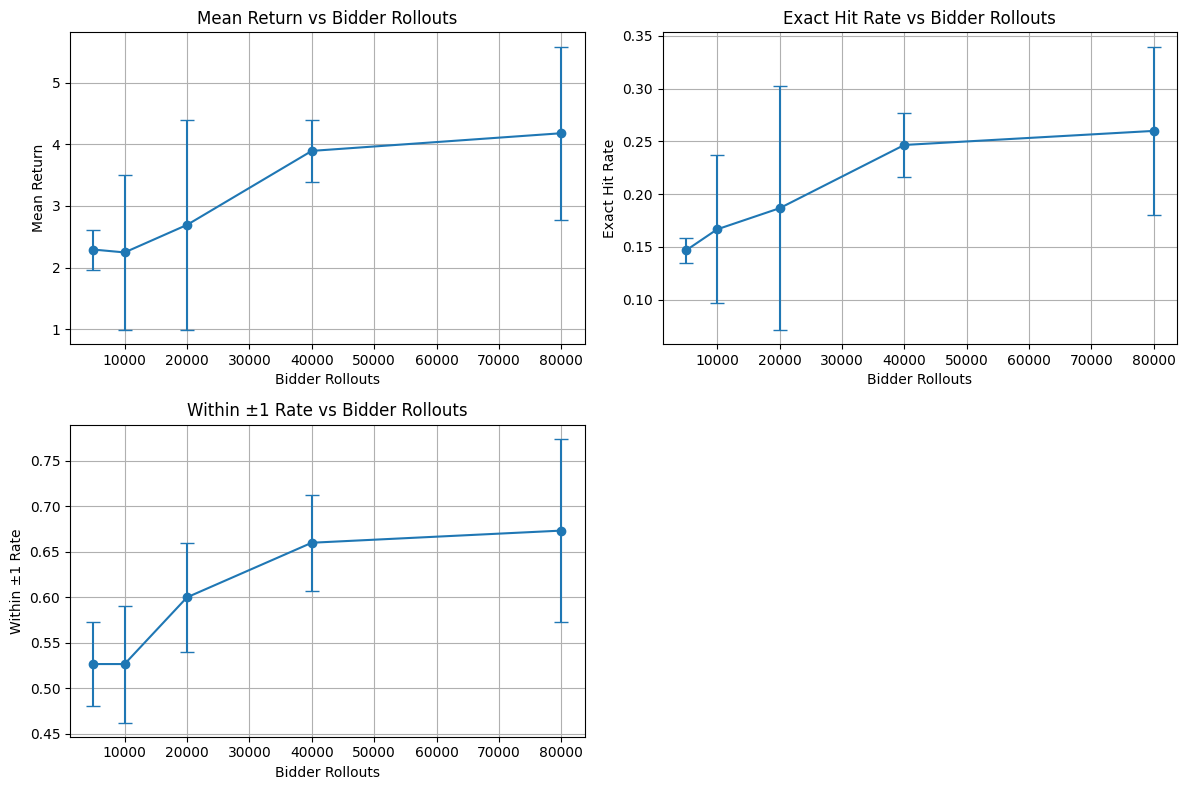

In [4]:
# --- Sensitivity: vary Bidder rollouts with error bars ---
import os, pandas as pd, matplotlib.pyplot as plt, numpy as np

# Fixed settings (kept small for faster testing)
cycles = 2
player_steps = 100_000
bidder_epochs = 4
eval_episodes = 50
n_envs = 4
learning_rate = 3e-4
ent_coef = 0.01
clip_range = 0.2

# Values to test
bidder_rollouts_list = [5_000, 10_000, 20_000, 40_000, 80_000]
seeds = [0, 1, 2]   # repeat per rollout value to estimate uncertainty

results = []
base_log_root = "bidder_rollout_test_runs"
base_ckpt_root = "bidder_rollout_test_ckpts"
os.makedirs(base_log_root, exist_ok=True)
os.makedirs(base_ckpt_root, exist_ok=True)

for br in bidder_rollouts_list:
    for seed in seeds:
        tag = f"bidder_rollouts_{br}_seed{seed}"
        log_dir = os.path.join(base_log_root, tag)
        save_dir = os.path.join(base_ckpt_root, tag)
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(save_dir, exist_ok=True)

        print(f"\n=== Testing bidder_rollouts = {br}, seed = {seed} ===")
        
        alternating_train(
            cycles=cycles,
            player_steps=player_steps,
            bidder_rollouts=br,
            bidder_epochs=bidder_epochs,
            seed=seed,
            save_dir=save_dir,
            eval_episodes=eval_episodes,
            log_dir=log_dir,
            eval_freq=50_000,
            tb_log_name="MaskablePPO",
            n_envs=n_envs,
        )

        # Collect final eval metrics
        final_csv = os.path.join(log_dir, "final_eval.csv")
        if os.path.exists(final_csv):
            final = pd.read_csv(final_csv).iloc[-1]
            mean_return = float(final["mean_return"])
            hit_exact = float(final["hit_exact"])
            within1 = float(final["within1"])
        else:
            mean_return = hit_exact = within1 = None

        # Collect 13-deal match score
        match_csv = os.path.join(log_dir, "match13_deals.csv")
        total_score = None
        if os.path.exists(match_csv):
            m = pd.read_csv(match_csv)
            t = m[m["deal"] == "TOTALS"]
            if not t.empty:
                total_score = int(t["cum_s0"].values[0])

        results.append({
            "bidder_rollouts": br,
            "seed": seed,
            "mean_return": mean_return,
            "hit_exact": hit_exact,
            "within1": within1,
            "total_score": total_score
        })

# Save all raw results
df = pd.DataFrame(results)
df.to_csv("bidder_rollouts_sensitivity_raw.csv", index=False)

# Aggregate mean & std
summary = df.groupby("bidder_rollouts").agg(
    mean_return_mean=("mean_return", "mean"),
    mean_return_std=("mean_return", "std"),
    hit_exact_mean=("hit_exact", "mean"),
    hit_exact_std=("hit_exact", "std"),
    within1_mean=("within1", "mean"),
    within1_std=("within1", "std"),
    total_score_mean=("total_score", "mean"),
    total_score_std=("total_score", "std"),
).reset_index()

summary.to_csv("bidder_rollouts_sensitivity_summary.csv", index=False)
print("\nBidder rollouts sensitivity results (mean ± std):")
print(summary)

# Plot with error bars
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.errorbar(summary["bidder_rollouts"], summary["mean_return_mean"], 
             yerr=summary["mean_return_std"], marker='o', capsize=5)
plt.xlabel('Bidder Rollouts')
plt.ylabel('Mean Return')
plt.title('Mean Return vs Bidder Rollouts')
plt.grid(True)

plt.subplot(222)
plt.errorbar(summary["bidder_rollouts"], summary["hit_exact_mean"], 
             yerr=summary["hit_exact_std"], marker='o', capsize=5)
plt.xlabel('Bidder Rollouts')
plt.ylabel('Exact Hit Rate')
plt.title('Exact Hit Rate vs Bidder Rollouts')
plt.grid(True)

plt.subplot(223)
plt.errorbar(summary["bidder_rollouts"], summary["within1_mean"], 
             yerr=summary["within1_std"], marker='o', capsize=5)
plt.xlabel('Bidder Rollouts')
plt.ylabel('Within ±1 Rate')
plt.title('Within ±1 Rate vs Bidder Rollouts')
plt.grid(True)


plt.tight_layout()
plt.savefig('bidder_rollouts_sensitivity_analysis.png', dpi=150)
plt.savefig('bidder_rollouts_sensitivity_analysis.pdf')
plt.show()


In [ ]:
# --- Sensitivity: vary Learning Rate with error bars ---
import os, pandas as pd, matplotlib.pyplot as plt, numpy as np

# Fixed settings
cycles = 2
player_steps = 50_000   # fixed at 100k for this experiment
bidder_rollouts = 20_000
bidder_epochs = 4
eval_episodes = 50
n_envs = 4
ent_coef = 0.01
clip_range = 0.2

# Learning rates to test
learning_rates = [ 3e-5, 1e-4, 3e-4, 1e-3, 3e-3,1e-2]  
seeds = [0, 1, 2]

results = []
base_log_root = "lr_test_runs"
base_ckpt_root = "lr_test_ckpts"
os.makedirs(base_log_root, exist_ok=True)
os.makedirs(base_ckpt_root, exist_ok=True)

for lr in learning_rates:
    for seed in seeds:
        tag = f"lr_{str(lr).replace('.', 'p')}_seed{seed}"
        log_dir = os.path.join(base_log_root, tag)
        save_dir = os.path.join(base_ckpt_root, tag)
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(save_dir, exist_ok=True)

        print(f"\n=== Testing learning_rate = {lr}, seed = {seed} ===")

        alternating_train(
            cycles=cycles,
            player_steps=player_steps,
            bidder_rollouts=bidder_rollouts,
            bidder_epochs=bidder_epochs,
            seed=seed,
            save_dir=save_dir,
            eval_episodes=eval_episodes,
            log_dir=log_dir,
            eval_freq=50_000,
            tb_log_name="MaskablePPO",
            n_envs=n_envs,
        )

        # Collect final eval metrics
        final_csv = os.path.join(log_dir, "final_eval.csv")
        if os.path.exists(final_csv):
            final = pd.read_csv(final_csv).iloc[-1]
            mean_return = float(final["mean_return"])
            hit_exact = float(final["hit_exact"])
            within1 = float(final["within1"])
        else:
            mean_return = hit_exact = within1 = None

        # Collect 13-deal match score
        match_csv = os.path.join(log_dir, "match13_deals.csv")
        total_score = None
        if os.path.exists(match_csv):
            m = pd.read_csv(match_csv)
            t = m[m["deal"] == "TOTALS"]
            if not t.empty:
                total_score = int(t["cum_s0"].values[0])

        results.append({
            "learning_rate": lr,
            "seed": seed,
            "mean_return": mean_return,
            "hit_exact": hit_exact,
            "within1": within1,
            "total_score": total_score
        })

# Save all raw results
df = pd.DataFrame(results)
df.to_csv("lr_sensitivity_raw.csv", index=False)

# Aggregate mean & std
summary = df.groupby("learning_rate").agg(
    mean_return_mean=("mean_return", "mean"),
    mean_return_std=("mean_return", "std"),
    hit_exact_mean=("hit_exact", "mean"),
    hit_exact_std=("hit_exact", "std"),
    within1_mean=("within1", "mean"),
    within1_std=("within1", "std"),
    total_score_mean=("total_score", "mean"),
    total_score_std=("total_score", "std"),
).reset_index()

summary.to_csv("lr_sensitivity_summary.csv", index=False)
print("\nLearning rate sensitivity results (mean ± std):")
print(summary)

# Plot with error bars
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.errorbar(summary["learning_rate"], summary["mean_return_mean"],
             yerr=summary["mean_return_std"], marker='o', capsize=5)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Return')
plt.title('Mean Return vs Learning Rate')
plt.grid(True)

plt.subplot(222)
plt.errorbar(summary["learning_rate"], summary["hit_exact_mean"],
             yerr=summary["hit_exact_std"], marker='o', capsize=5)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Exact Hit Rate')
plt.title('Exact Hit Rate vs Learning Rate')
plt.grid(True)

plt.subplot(223)
plt.errorbar(summary["learning_rate"], summary["within1_mean"],
             yerr=summary["within1_std"], marker='o', capsize=5)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Within ±1 Rate')
plt.title('Within ±1 Rate vs Learning Rate')
plt.grid(True)


plt.tight_layout()
plt.savefig('lr_sensitivity_analysis.png', dpi=150)
plt.savefig('lr_sensitivity_analysis.pdf')
plt.show()



=== Testing learning_rate = 3e-05, seed = 0 ===
Logging to lr_test_runs\lr_3e-05_seed0

=== CYCLE 1/2: Train PLAYER (50,000 steps) with current BIDDER ===
-----------------------------
| time/              |      |
|    fps             | 1566 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1348         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0023595216 |
|    clip_fraction        | 0.000684     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.012        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.63         |
|    n_updates            | 10  

### 5 Cycles

In [ ]:
"""
end_to_end_estimation.py

One-system Estimation / Oh Hell trainer:
- Distributional Bidder (PyTorch): P(tricks = k | hand, trump), picks bid maximizing Estimation score
- Playing Agent (MaskablePPO): learns to hit the chosen bid (seat 0 only)
- Opponents (seats 1–3): follow suit and play a high legal card with slight randomness (±2 ranks of best)
- Alternating training: Player RL steps <-> Bidder supervised calibration on realized trick counts
- Final test: run 13 deals and compare total Oh Hell points of seat 0 vs all other seats
- Rich tracking — TensorBoard + CSV logs, periodic eval callback logging task metrics
- Faster wall-clock (no learning compromises):
    * SubprocVecEnv parallelism (keep rollout size constant)
    * O(1) rank lookups
    * Thread settings for BLAS / Torch
    * Quieter console

Run (example):
  python end_to_end_estimation.py --cycles 5 --player_steps 2000000 --bidder_rollouts 120000 --bidder_epochs 8 --eval_episodes 300 --log_dir runs/exp1 --eval_freq 20000 --n_envs 8
"""

# ==========================
# Fast-thread settings FIRST
# ==========================
import os
# Set BEFORE importing numpy / torch / sb3 (they may create thread pools on import)
os.environ.setdefault("OMP_NUM_THREADS", "8")   # tune to your CPU
os.environ.setdefault("MKL_NUM_THREADS", "8")   # tune to your CPU

import sys
import math
import random
import argparse
import csv
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# ---- Safe imports for RL; show a clear message if missing ----
try:
    from sb3_contrib import MaskablePPO
    from sb3_contrib.common.wrappers import ActionMasker
    from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
    from stable_baselines3.common.callbacks import BaseCallback
    from stable_baselines3.common.logger import configure as sb3_logger_configure
except Exception as e:
    raise RuntimeError(
        'Stable-Baselines3 and sb3-contrib are required.\n'
        'Install with:\n  pip install "stable-baselines3>=2.3.0" "sb3-contrib>=2.3.0"'
    ) from e

# ---- PyTorch for the bidder ----
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    # Use CPU threads effectively
    try:
        torch.set_num_threads(int(os.environ.get("OMP_NUM_THREADS", "8")))
    except Exception:
        pass
    # Slightly faster matmul kernels on CPU for PyTorch 2.x
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass
except Exception as e:
    raise RuntimeError(
        'PyTorch is required for the bidder.\n'
        'Install with:\n  pip install torch'
    ) from e

import gymnasium as gym
from gymnasium import spaces


# ================
# CSV helper
# ================
def _append_row_csv(path: str, row: dict):
    """Append a row (dict) to CSV, writing headers on first write."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    write_header = not os.path.exists(path)
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if write_header:
            w.writeheader()
        w.writerow(row)


# ================
# Card definitions
# ================
SUITS = ["H", "S", "D", "C"]
RANKS = ["2","3","4","5","6","7","8","9","10","J","Q","K","A"]
RANK_TO_IDX = {r: i for i, r in enumerate(RANKS)}  # O(1) rank lookup
PAD = 52
CARD_IDX = {f"{r}{s}": i for i, (s, r) in enumerate((s, r) for s in SUITS for r in RANKS)}
IDX_CARD = {v: k for k, v in CARD_IDX.items()}

def card_suit(card: str) -> str:
    return card[-1]

def card_rank(card: str) -> str:
    return card[:-1]

def get_trick_winner(trick: List[str], trump: Optional[str]) -> int:
    """Winner: any trump beats non-trump; otherwise highest rank in led suit."""
    lead_suit = card_suit(trick[0])
    best_idx = 0
    best_card = trick[0]
    for i, card in enumerate(trick[1:], 1):
        c_suit, b_suit = card_suit(card), card_suit(best_card)
        if trump is not None:
            if c_suit == trump and b_suit != trump:
                best_idx, best_card = i, card
                continue
            if c_suit == trump and b_suit == trump:
                if RANK_TO_IDX[card_rank(card)] > RANK_TO_IDX[card_rank(best_card)]:
                    best_idx, best_card = i, card
                continue
        # compare within led suit if best isn't trump
        if (trump is None or b_suit != trump) and c_suit == lead_suit:
            if RANK_TO_IDX[card_rank(card)] > RANK_TO_IDX[card_rank(best_card)]:
                best_idx, best_card = i, card
    return best_idx

def lowest_legal_index(hand: List[str], led: Optional[str]) -> int:
    indices = list(range(len(hand)))
    if led is not None and any(card_suit(c) == led for c in hand):
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices if card_suit(hand[i]) == led]
    else:
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices]
    candidates.sort()
    return candidates[0][1]

def highest_with_fuzz_legal_index(hand: List[str], led: Optional[str]) -> int:
    """
    Improved opponent heuristic:
      - If led suit is present: consider only cards in led suit.
      - Otherwise: consider all cards.
      - Play a high card, with randomness: choose among cards within ±2 ranks of the highest.
    """
    indices = list(range(len(hand)))
    if len(indices) == 0:
        return 0
    if led is not None and any(card_suit(c) == led for c in hand):
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices if card_suit(hand[i]) == led]
    else:
        candidates = [(RANK_TO_IDX[card_rank(hand[i])], i) for i in indices]
    candidates.sort(reverse=True)
    top_rank = candidates[0][0]
    threshold = max(0, top_rank - 2)
    near_top = [pair for pair in candidates if pair[0] >= threshold]
    choice = random.choice(near_top) if near_top else candidates[0]
    return choice[1]


# ===================
# Playing environment
# ===================
class PlayingEnvSeat0(gym.Env):
    """
    4-player trick-taking env; only seat 0 is controlled by the agent.
    Seats 1..3 play a stronger legal policy:
      - Follow suit if possible
      - Otherwise free choice
      - Prefer the highest legal card, with slight randomness: choose among cards within ±2 ranks of the highest.

    - 52 cards, 13-card hands, 13 tricks
    - trump suit provided externally each episode
    - follow-suit enforced
    - action masking for seat 0
    - dense shaping toward the bid (seat 0) + terminal Estimation scoring
    """
    metadata = {"render_modes": []}

    def __init__(self):
        super().__init__()
        self.num_players = 4
        self.hand_size = 13
        self.deck = [f"{r}{s}" for s in SUITS for r in RANKS]

        self.bids = [0,0,0,0]
        self.trump: Optional[str] = None

        self.action_space = spaces.Discrete(self.hand_size)
        self.observation_space = spaces.Dict({
            "hand":   spaces.MultiDiscrete([PAD + 1] * self.hand_size),
            "trick":  spaces.MultiDiscrete([PAD + 1] * 4),
            "bids":   spaces.MultiDiscrete([14] * 4),
            "won":    spaces.MultiDiscrete([14] * 4),
            "trump":  spaces.Discrete(4),
            "seat":   spaces.Discrete(4),
            "leader": spaces.Discrete(4),
        })

        self.players: List[List[str]] = [[] for _ in range(self.num_players)]
        self.won_tricks = [0]*self.num_players
        self.current_trick: List[str] = []
        self.current_player = 0
        self.leader = 0
        self.trick_history: List[List[str]] = []

        self._prev_abs_diff = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        deck = self.deck[:]
        random.shuffle(deck)
        self.players = [deck[i*self.hand_size:(i+1)*self.hand_size] for i in range(self.num_players)]
        self.won_tricks = [0]*self.num_players
        self.current_trick = []
        self.trick_history = []
        self.current_player = self.leader = 0
        self._prev_abs_diff = abs(self.won_tricks[0] - self.bids[0])
        return self._get_obs(), {}

    def _pad_cards(self, cards: List[str], target_len: int) -> np.ndarray:
        arr = [CARD_IDX[c] for c in cards] + [PAD] * (target_len - len(cards))
        return np.array(arr, dtype=np.int64)

    def _get_obs(self):
        trump_idx = SUITS.index(self.trump) if self.trump is not None else 0
        return {
            "hand":   self._pad_cards(self.players[0], self.hand_size),
            "trick":  self._pad_cards(self.current_trick, 4),
            "bids":   np.array(self.bids, dtype=np.int64),
            "won":    np.array(self.won_tricks, dtype=np.int64),
            "trump":  np.array(trump_idx, dtype=np.int64),
            "seat":   np.array(0, dtype=np.int64),
            "leader": np.array(self.leader, dtype=np.int64),
        }

    def _legal_action_mask(self):
        mask = np.zeros(self.hand_size, dtype=np.int8)
        hand = self.players[0]
        n = len(hand)
        if n == 0:
            return mask
        mask[:n] = 1
        if len(self.current_trick) == 0 or self.current_player != 0:
            return mask
        led = card_suit(self.current_trick[0])
        if any(card_suit(c) == led for c in hand):
            for i in range(n):
                if card_suit(hand[i]) != led:
                    mask[i] = 0
        return mask

    def _opponent_play_one_card(self):
        assert self.current_player != 0
        hand = self.players[self.current_player]
        led = card_suit(self.current_trick[0]) if len(self.current_trick) > 0 else None
        idx = highest_with_fuzz_legal_index(hand, led)
        card = hand.pop(idx)
        self.current_trick.append(card)
        if len(self.current_trick) == 4:
            winner_offset = get_trick_winner(self.current_trick, trump=self.trump)
            winner = (self.leader + winner_offset) % self.num_players
            self.won_tricks[winner] += 1
            self.trick_history.append(self.current_trick[:])
            self.current_trick.clear()
            self.leader = winner
            self.current_player = winner
        else:
            self.current_player = (self.current_player + 1) % self.num_players

    def _advance_to_seat0_or_end(self) -> float:
        shaping = 0.0
        while len(self.trick_history) < self.hand_size and self.current_player != 0:
            prev = abs(self.won_tricks[0] - self.bids[0])
            self._opponent_play_one_card()
            new = abs(self.won_tricks[0] - self.bids[0])
            if len(self.current_trick) == 0:
                shaping += (prev - new)
        return shaping

    def step(self, action: int):
        if len(self.trick_history) == self.hand_size:
            return self._get_obs(), 0.0, True, False, {"action_mask": self._legal_action_mask()}

        total_reward = 0.0

        if self.current_player != 0:
            total_reward += self._advance_to_seat0_or_end()
            if len(self.trick_history) == self.hand_size:
                final = self._final_score()
                return self._get_obs(), total_reward + final, True, False, {"action_mask": self._legal_action_mask()}

        hand = self.players[0]
        if not (0 <= action < len(hand)):
            raise IndexError(f"Invalid action {action} for hand length {len(hand)}")

        card = hand.pop(action)
        self.current_trick.append(card)

        if len(self.current_trick) == 4:
            prev = abs(self.won_tricks[0] - self.bids[0])
            winner_offset = get_trick_winner(self.current_trick, trump=self.trump)
            winner = (self.leader + winner_offset) % self.num_players
            self.won_tricks[winner] += 1
            self.trick_history.append(self.current_trick[:])
            self.current_trick.clear()
            self.leader = winner
            self.current_player = winner
            new = abs(self.won_tricks[0] - self.bids[0])
            total_reward += (prev - new)
        else:
            self.current_player = (self.current_player + 1) % self.num_players

        total_reward += self._advance_to_seat0_or_end()

        done = len(self.trick_history) == self.hand_size
        if done:
            total_reward += self._final_score()

        info = {"action_mask": self._legal_action_mask()}
        return self._get_obs(), total_reward, done, False, info

    def _final_score(self) -> float:
        bid = self.bids[0]
        won = self.won_tricks[0]
        return (10 + bid) if won == bid else -abs(won - bid)


# ===========================
# Distributional bidder (NN)
# ===========================
def encode_features(hand: List[str], trump: str) -> np.ndarray:
    x = np.zeros(56, dtype=np.float32)
    for c in hand:
        x[CARD_IDX[c]] = 1.0
    x[52 + SUITS.index(trump)] = 1.0
    return x

class BidderNet(nn.Module):
    def __init__(self, in_dim=56, hidden=256, dropout=0.1, out_dim=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

@dataclass
class Bidder:
    model: BidderNet
    device: str = "cpu"

    @staticmethod
    def create(device: Optional[str] = None) -> "Bidder":
        if device is None or device == "auto":
            device = "cuda" if torch.cuda.is_available() else "cpu"
        m = BidderNet().to(device)
        return Bidder(model=m, device=device)

    def save(self, path: str):
        torch.save(self.model.state_dict(), path)

    def load(self, path: str):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.eval()

    @torch.no_grad()
    def predict_distribution(self, hand: List[str], trump: str) -> np.ndarray:
        x = torch.from_numpy(encode_features(hand, trump)).unsqueeze(0).to(self.device)
        logits = self.model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        return probs

    def pick_bid_max_expected_score(self, probs: np.ndarray) -> int:
        k = np.arange(14)
        best_b, best_val = 0, -1e9
        for b in range(14):
            expected = probs[b] * (10 + b) + np.sum(probs * (-np.abs(k - b)))
            if expected > best_val:
                best_val, best_b = expected, b
        return int(best_b)

    def train_supervised(self, X: np.ndarray, y: np.ndarray,
                         epochs: int = 6, batch_size: int = 2048, lr: float = 1e-3, seed: int = 42):
        torch.manual_seed(seed)
        self.model.train()
        opt = optim.AdamW(self.model.parameters(), lr=lr)
        crit = nn.CrossEntropyLoss()

        X_t = torch.from_numpy(X).to(self.device)
        y_t = torch.from_numpy(y.astype(np.int64)).to(self.device)

        n = X.shape[0]
        steps = math.ceil(n / batch_size) if n > 0 else 0
        for ep in range(1, epochs + 1):
            if n == 0:
                print(f"[Bidder] Epoch {ep}/{epochs}  loss=0.0000 (no data)")
                continue
            perm = torch.randperm(n, device=self.device)
            total = 0.0
            for b in range(steps):
                idx = perm[b*batch_size:(b+1)*batch_size]
                xb, yb = X_t[idx], y_t[idx]
                opt.zero_grad()
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
                total += loss.item() * xb.size(0)
            avg = total / n
            print(f"[Bidder] Epoch {ep}/{epochs}  loss={avg:.4f}")
        self.model.eval()


# ==========================
# Wrapper: inject bids/trump
# ==========================
def deterministic_trump_from_seed(seed: int) -> str:
    return SUITS[seed % 4]

class DealBidInjectingEnv(PlayingEnvSeat0):
    def __init__(self, bidder: Bidder):
        super().__init__()
        self._bidder = bidder
        self._last_hand0: List[str] = []
        self._last_features: Optional[np.ndarray] = None

    def reset(self, seed=None, options=None):
        self._shared_seed = int(np.random.randint(0, 2**31-1)) if seed is None else int(seed)
        obs, info = super().reset(seed=self._shared_seed, options=options)
        self.trump = deterministic_trump_from_seed(self._shared_seed)
        self._last_hand0 = self.players[0][:]
        probs = self._bidder.predict_distribution(self._last_hand0, self.trump)
        bid0 = self._bidder.pick_bid_max_expected_score(probs)

        def simple_bid_bot(hand: List[str], trump: str) -> int:
            high_trump = {"A","10","K","Q","J"}
            high = {"A","10","K"}
            v = sum(1 for c in hand if card_suit(c)==trump and card_rank(c) in high_trump) \
                + sum(1 for c in hand if card_rank(c) in high)
            v += random.choice([-2,-1,0,1,2])
            return max(0, min(13, v))

        bids = [bid0] + [simple_bid_bot(self.players[i], self.trump) for i in range(1,4)]
        self.bids = bids
        self._last_features = encode_features(self._last_hand0, self.trump)
        return self._get_obs(), info


# ==========================
# RL utilities & evaluation
# ==========================
def mask_fn(env: PlayingEnvSeat0):
    return env._legal_action_mask()

def make_vec_env(bidder: Bidder, n_envs: int = 8, use_subproc: bool = True):
    def _make():
        e = DealBidInjectingEnv(bidder)
        return ActionMasker(e, mask_fn)
    if n_envs == 1:
        return DummyVecEnv([_make])
    if use_subproc:
        return SubprocVecEnv([_make for _ in range(n_envs)])
    return DummyVecEnv([_make for _ in range(n_envs)])

def evaluate_player(model: MaskablePPO, bidder: Bidder, episodes: int = 50):
    env = ActionMasker(DealBidInjectingEnv(bidder), mask_fn)
    returns, hits, within1 = [], 0, 0
    for _ in range(episodes):
        obs, _ = env.reset()
        ep_ret, done = 0.0, False
        while not done:
            base = env.unwrapped
            mask = base._legal_action_mask()
            action, _ = model.predict(obs, deterministic=True, action_masks=mask)
            obs, reward, done, truncated, _ = env.step(int(action))
            ep_ret += float(reward)
            if truncated:
                break
        returns.append(ep_ret)
        b0, w0 = base.bids[0], base.won_tricks[0]
        if b0 == w0: hits += 1
        if abs(b0 - w0) <= 1: within1 += 1
    mean, std = float(np.mean(returns)), float(np.std(returns))
    hit_rate = hits/episodes
    within1_rate = within1/episodes
    print(f"[Eval] {episodes} eps  mean={mean:.3f} ± {std:.3f} | hit_exact={hit_rate:.3f} | within±1={within1_rate:.3f}")
    return {
        "episodes": episodes,
        "mean_return": mean,
        "std_return": std,
        "hit_exact": hit_rate,
        "within1": within1_rate,
    }

def oh_hell_points(bid: int, won: int) -> int:
    return (10 + bid) if won == bid else -abs(won - bid)

def run_13_deal_match(model: MaskablePPO, bidder: Bidder, seed: Optional[int] = None,
                      csv_path: Optional[str] = None) -> List[int]:
    totals = [0, 0, 0, 0]
    env = ActionMasker(DealBidInjectingEnv(bidder), mask_fn)
    rng = random.Random(seed)

    deal_rows = []

    for d in range(13):
        deal_seed = None if seed is None else (rng.randrange(0, 2**31 - 1))
        obs, _ = env.reset(seed=deal_seed)
        done = False
        while not done:
            base = env.unwrapped
            mask = base._legal_action_mask()
            action, _ = model.predict(obs, deterministic=True, action_masks=mask)
            obs, reward, done, truncated, _ = env.step(int(action))
            if truncated:
                break
        base = env.unwrapped
        pts = [oh_hell_points(base.bids[s], base.won_tricks[s]) for s in range(4)]
        for s in range(4):
            totals[s] += pts[s]

        print(f"[Deal {d+1:02d}] Bids={base.bids}  Won={base.won_tricks}  Points={pts}")

        row = {
            "deal": d + 1,
            "bid_s0": base.bids[0], "bid_s1": base.bids[1], "bid_s2": base.bids[2], "bid_s3": base.bids[3],
            "won_s0": base.won_tricks[0], "won_s1": base.won_tricks[1], "won_s2": base.won_tricks[2], "won_s3": base.won_tricks[3],
            "pts_s0": pts[0], "pts_s1": pts[1], "pts_s2": pts[2], "pts_s3": pts[3],
            "cum_s0": totals[0], "cum_s1": totals[1], "cum_s2": totals[2], "cum_s3": totals[3],
        }
        deal_rows.append(row)

    print("\n[13-Deal Match] Total points:")
    for s in range(4):
        tag = "Seat0 (Agent)" if s == 0 else f"Seat{s}"
        print(f"  {tag}: {totals[s]}")
    ranking = sorted([(totals[s], s) for s in range(4)], reverse=True)
    rank_str = " > ".join([("Seat0* (Agent)" if s == 0 else f"Seat{s}") for _, s in ranking])
    print(f"[13-Deal Match] Ranking: {rank_str}")

    if csv_path is not None:
        # ensure a fresh file
        try:
            if os.path.exists(csv_path):
                os.remove(csv_path)
        except Exception:
            pass
        # write all deals
        for r in deal_rows:
            _append_row_csv(csv_path, r)
        # add a final TOTALS row
        totals_row = {
            "deal": "TOTALS",
            "bid_s0": "", "bid_s1": "", "bid_s2": "", "bid_s3": "",
            "won_s0": "", "won_s1": "", "won_s2": "", "won_s3": "",
            "pts_s0": "", "pts_s1": "", "pts_s2": "", "pts_s3": "",
            "cum_s0": totals[0], "cum_s1": totals[1], "cum_s2": totals[2], "cum_s3": totals[3],
        }
        _append_row_csv(csv_path, totals_row)

    return totals


# ==========================
# Periodic Eval Callback
# ==========================
class PeriodicEvalCallback(BaseCallback):
    """
    Runs short deterministic evaluations every eval_freq steps with the current bidder,
    logs metrics to SB3 logger (TensorBoard/CSV/stdout).
    """
    def __init__(self, bidder: Bidder, eval_episodes: int = 10, eval_freq: int = 50_000, verbose: int = 0):
        super().__init__(verbose)
        self.bidder = bidder
        self.eval_episodes = eval_episodes
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            metrics = evaluate_player(self.model, self.bidder, episodes=self.eval_episodes)
            # Log to SB3 logger
            self.model.logger.record("eval/mean_return", metrics["mean_return"])
            self.model.logger.record("eval/std_return", metrics["std_return"])
            self.model.logger.record("eval/hit_exact", metrics["hit_exact"])
            self.model.logger.record("eval/within1", metrics["within1"])
            self.model.logger.dump(self.num_timesteps)
        return True


# ==========================
# Plotting utilities
# ==========================
def _ema(y, a=0.1):
    if a <= 0: return y
    out=[]; m=None
    for v in y: m=v if m is None else a*v + (1-a)*m; out.append(m)
    return np.array(out)

def _coalesce_timesteps(df):
    for c in ["time/total_timesteps","total_timesteps","timesteps"]:
        if c in df.columns:
            return df.rename(columns={c:"total_timesteps"})
    df = df.copy(); df["total_timesteps"] = np.arange(len(df)); return df

def _plot_series(df, cols, title, ylabel, out_path, smooth=0.1):
    plt.figure(figsize=(8,5))
    any_plot = False
    for c in cols:
        if c in df.columns:
            plt.plot(df["total_timesteps"].values, _ema(df[c].values, smooth), label=c)
            any_plot = True
    if not any_plot:
        print(f"[Plots] Skipped {title}: none of {cols} found"); return
    plt.xlabel("Total timesteps"); plt.ylabel(ylabel); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(out_path + ".png", dpi=150); plt.savefig(out_path + ".pdf"); plt.close()

def plot_learning_curves(log_dir, out_dir=None, smooth=0.1):
    paths = glob(os.path.join(log_dir, "**", "progress.csv"), recursive=True)
    if not paths:
        print(f"[Plots] No progress.csv under {log_dir}"); return
    dfs = []
    for p in sorted(paths):
        try:
            d = pd.read_csv(p); d["__src"] = p; dfs.append(d)
        except Exception as e:
            print(f"[Plots] Skip {p}: {e}")
    if not dfs:
        print("[Plots] No readable CSV logs."); return
    df = pd.concat(dfs, ignore_index=True, sort=False)
    df = _coalesce_timesteps(df)
    df = df.sort_values("total_timesteps").drop_duplicates(subset=["total_timesteps","__src"], keep="last")
    out_dir = out_dir or os.path.join(log_dir, "plots")
    os.makedirs(out_dir, exist_ok=True)
    _plot_series(df,
        ["eval/mean_return","cycle/post_player/mean_return","cycle/post_bidder/mean_return","final/mean_return"],
        "Learning: Mean Return vs Timesteps","Mean episodic return", os.path.join(out_dir, "mean_return"), smooth)
    _plot_series(df,
        ["eval/hit_exact","cycle/post_player/hit_exact","cycle/post_bidder/hit_exact","final/hit_exact"],
        "Learning: Exact-Hit Rate vs Timesteps","Exact-hit rate", os.path.join(out_dir, "hit_exact"), smooth)
    _plot_series(df,
        ["eval/within1","cycle/post_player/within1","cycle/post_bidder/within1","final/within1"],
        "Learning: Within ±1 Rate vs Timesteps","Within ±1 rate", os.path.join(out_dir, "within1"), smooth)
    print(f"[Plots] Saved to {out_dir}")


# ==========================
# Alternating training loop
# ==========================
def collect_bidder_dataset(player: MaskablePPO, bidder: Bidder, n_episodes: int) -> Tuple[np.ndarray, np.ndarray]:
    env = ActionMasker(DealBidInjectingEnv(bidder), mask_fn)
    X_list, y_list = [], []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        base = env.unwrapped
        done = False
        while not done:
            mask = base._legal_action_mask()
            action, _ = player.predict(obs, deterministic=True, action_masks=mask)
            obs, reward, done, truncated, _ = env.step(int(action))
            if truncated:
                break
        feats = base._last_features
        label = base.won_tricks[0]
        if feats is not None:
            X_list.append(feats)
            y_list.append(int(label))
    X = np.stack(X_list, axis=0) if X_list else np.zeros((0,56), dtype=np.float32)
    y = np.array(y_list, dtype=np.int64) if y_list else np.zeros((0,), dtype=np.int64)
    print(f"[Dataset] Collected {len(y)} bidder samples.")
    return X, y


def alternating_train(
    cycles: int = 3,
    player_steps: int = 600_000,
    bidder_rollouts: int = 30_000,
    bidder_epochs: int = 6,
    seed: int = 42,
    save_dir: str = "ckpts",
    eval_episodes: int = 100,
    log_dir: str = "runs/exp",
    eval_freq: int = 50_000,
    tb_log_name: str = "MaskablePPO",
    n_envs: int = 8,                # NEW: parallel envs
):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # init bidder
    bidder = Bidder.create(device="auto")

    # init player with parallel envs; keep rollout-size constant (n_steps*n_envs == 1024)
    vec_env = make_vec_env(bidder, n_envs=n_envs, use_subproc=True)
    target_rollout = 1024
    n_steps = max(64, target_rollout // max(1, n_envs))

    player = MaskablePPO(
        policy="MultiInputPolicy",
        env=vec_env,
        seed=seed,
        verbose=0,                 # quieter -> less overhead
        n_steps=n_steps,
        batch_size=256,
        learning_rate=3e-4,
        ent_coef=0.01,
        clip_range=0.2,
        gamma=0.99,
        gae_lambda=0.95,
        n_epochs=10,
        tensorboard_log=log_dir
    )

    # Configure SB3 logger to also write CSV + stdout
    sb3_logger = sb3_logger_configure(log_dir, ["stdout", "csv", "tensorboard"])
    player.set_logger(sb3_logger)

    for cyc in range(1, cycles + 1):
        print(f"\n=== CYCLE {cyc}/{cycles}: Train PLAYER ({player_steps:,} steps) with current BIDDER ===")
        callback = PeriodicEvalCallback(
            bidder=bidder,
            eval_episodes=max(5, eval_episodes//10),
            eval_freq=eval_freq,
            verbose=0
        )
        player.learn(total_timesteps=player_steps, progress_bar=False, callback=callback, tb_log_name=f"{tb_log_name}_cycle{cyc}")

        # save checkpoint
        player_path = os.path.join(save_dir, f"player_cycle{cyc}")
        player.save(player_path)
        bidder_path = os.path.join(save_dir, f"bidder_cycle{cyc}.pt")
        bidder.save(bidder_path)
        print(f"[Save] {player_path}.zip and {bidder_path}")

        # --- Evaluate after player training ---
        print(f"\n--- Evaluate after player training ---")
        eval_ep = max(20, eval_episodes//5)
        metrics_player = evaluate_player(player, bidder, episodes=eval_ep)

        # Log to SB3
        player.logger.record("cycle/post_player/mean_return", metrics_player["mean_return"])
        player.logger.record("cycle/post_player/std_return",  metrics_player["std_return"])
        player.logger.record("cycle/post_player/hit_exact",   metrics_player["hit_exact"])
        player.logger.record("cycle/post_player/within1",     metrics_player["within1"])
        player.logger.dump(player.num_timesteps)

        # Save to per-cycle CSV
        cycle_csv = os.path.join(log_dir, f"cycle_{cyc}.csv")
        row_player = {
            "cycle": cyc,
            "phase": "post_player",
            "timesteps": player.num_timesteps,
            **metrics_player,
        }
        _append_row_csv(cycle_csv, row_player)

        # --- Train BIDDER on realized tricks ---
        print(f"\n=== CYCLE {cyc}/{cycles}: Train BIDDER on realized tricks from current PLAYER ===")
        X, y = collect_bidder_dataset(player, bidder, n_episodes=bidder_rollouts)
        if len(y) == 0:
            print("[Warn] No data collected for bidder; skipping bidder update.")
        else:
            bidder.train_supervised(X, y, epochs=bidder_epochs, batch_size=8192, lr=1e-3, seed=seed)
            bidder_updated_path = os.path.join(save_dir, f"bidder_cycle{cyc}_updated.pt")
            bidder.save(bidder_updated_path)

        # rebind env to use updated bidder
        vec_env = make_vec_env(bidder, n_envs=n_envs, use_subproc=True)
        player.set_env(vec_env)

        # --- Evaluate after bidder update ---
        print(f"\n--- Evaluate after bidder update ---")
        metrics_bidder = evaluate_player(player, bidder, episodes=eval_ep)

        # Log to SB3
        player.logger.record("cycle/post_bidder/mean_return", metrics_bidder["mean_return"])
        player.logger.record("cycle/post_bidder/std_return",  metrics_bidder["std_return"])
        player.logger.record("cycle/post_bidder/hit_exact",   metrics_bidder["hit_exact"])
        player.logger.record("cycle/post_bidder/within1",     metrics_bidder["within1"])
        player.logger.dump(player.num_timesteps)

        # Append to same per-cycle CSV
        row_bidder = {
            "cycle": cyc,
            "phase": "post_bidder",
            "timesteps": player.num_timesteps,
            **metrics_bidder,
        }
        _append_row_csv(cycle_csv, row_bidder)

    # === FINAL EVALUATION ===
    print("\n=== FINAL EVALUATION ===")
    final_metrics = evaluate_player(player, bidder, episodes=eval_episodes)
    player.logger.record("final/mean_return", final_metrics["mean_return"])
    player.logger.record("final/std_return",  final_metrics["std_return"])
    player.logger.record("final/hit_exact",   final_metrics["hit_exact"])
    player.logger.record("final/within1",     final_metrics["within1"])
    player.logger.dump(player.num_timesteps)

    # Save final eval CSV
    final_csv = os.path.join(log_dir, "final_eval.csv")
    _append_row_csv(final_csv, {
        "phase": "final",
        "timesteps": player.num_timesteps,
        **final_metrics,
    })

    # === 13-DEAL MATCH ===
    print("\n=== 13-DEAL MATCH VS OPPONENTS (NORMAL OH HELL SCORING) ===")
    match_csv = os.path.join(log_dir, "match13_deals.csv")
    try:
        if os.path.exists(match_csv):
            os.remove(match_csv)
    except Exception:
        pass
    totals = run_13_deal_match(player, bidder, seed=seed, csv_path=match_csv)

    # Log 13-deal totals to SB3
    player.logger.record("match13/seat0_agent", totals[0])
    player.logger.record("match13/seat1", totals[1])
    player.logger.record("match13/seat2", totals[2])
    player.logger.record("match13/seat3", totals[3])
    player.logger.record("match13/agent_is_best", float(totals[0] == max(totals)))
    player.logger.dump(player.num_timesteps)

    # Save final models
    final_player = os.path.join(save_dir, "player_final")
    final_bidder = os.path.join(save_dir, "bidder_final.pt")
    player.save(final_player)
    bidder.save(final_bidder)
    print(f"[Final Save] {final_player}.zip and {final_bidder}")

    # Plots at end (optional)
    try:
        plot_learning_curves(log_dir, out_dir=os.path.join(log_dir, "plots"), smooth=0.1)
    except Exception as e:
        print(f"[Plots] Skipped (reason: {e})")


# ==========================
# CLI / Notebook entrypoint
# ==========================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--cycles", type=int, default=5)
    parser.add_argument("--player_steps", type=int, default=1_000_000)
    parser.add_argument("--bidder_rollouts", type=int, default=120_000)
    parser.add_argument("--bidder_epochs", type=int, default=8)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--save_dir", type=str, default="ckpts")
    parser.add_argument("--eval_episodes", type=int, default=300)
    # Logging / eval
    parser.add_argument("--log_dir", type=str, default="runs/exp1")
    parser.add_argument("--eval_freq", type=int, default=20_000, help="Periodic eval every N steps during PPO.learn()")
    parser.add_argument("--tb_log_name", type=str, default="MaskablePPO", help="TensorBoard run name per cycle")
    # NEW: parallel envs
    parser.add_argument("--n_envs", type=int, default=8, help="Number of parallel environments for PPO")
    args, _ = parser.parse_known_args()

    alternating_train(
        cycles=args.cycles,
        player_steps=args.player_steps,
        bidder_rollouts=args.bidder_rollouts,
        bidder_epochs=args.bidder_epochs,
        seed=args.seed,
        save_dir=args.save_dir,
        eval_episodes=args.eval_episodes,
        log_dir=args.log_dir,
        eval_freq=args.eval_freq,
        tb_log_name=args.tb_log_name,
        n_envs=args.n_envs,
    )

if __name__ == "__main__":
    main()
